In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora/sample_submission.csv
/kaggle/input/quora/train.csv
/kaggle/input/quora/test.csv


In [14]:
print('Importing Libraries')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
pd.set_option('display.max_columns', None)  
#pd.set_option('display.expand_frame_repr', False)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


Importing Libraries


In [15]:
print('Loading Datasets')

train=pd.read_csv('/kaggle/input/quora/train.csv')
test=pd.read_csv('/kaggle/input/quora/test.csv')

Loading Datasets


In [16]:
print('Given training dataset has {} columns and {} rows.'.format(train.shape[1], train.shape[0]))

Given training dataset has 3 columns and 783673 rows.


In [17]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783673 entries, 0 to 783672
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            783673 non-null  object
 1   question_text  783673 non-null  object
 2   target         783673 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 17.9+ MB
None


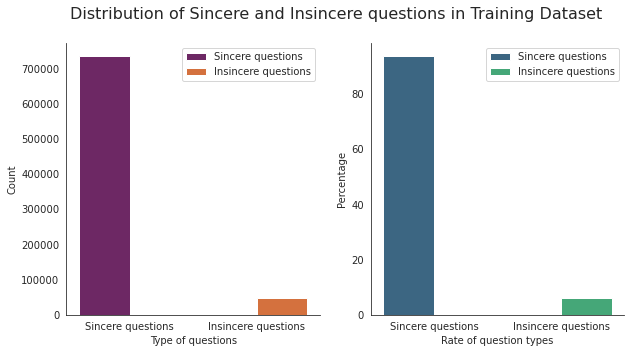

In [18]:
# Distribution of sincere and insincere questions

#total number of questions belonging to each target class
train_sincere = (train['target'] == 0).sum()
train_insincere = (train['target'] == 1).sum()

#percentage of sincere and insincere questions
train_sincere_per = (train_sincere/(train_sincere + train_insincere)*100)
train_insincere_per = (train_insincere/(train_sincere + train_insincere)*100)

train_questions = [train_sincere, train_insincere]
train_questions_per=[train_sincere_per, train_insincere_per]
sns.set_style('white')
sns.color_palette("Set2")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
plt.suptitle('Distribution of Sincere and Insincere questions in Training Dataset', fontsize=16)
x = ['Sincere questions','Insincere questions']
y = train_questions
sns.barplot(x=x, y=y, ax=ax1, palette="inferno", hue = x)
ax1.set_xlabel("Type of questions")
ax1.set_ylabel("Count")
x = ['Sincere questions','Insincere questions']
y = train_questions_per
sns.barplot(x=x, y=y, ax=ax2, palette="viridis", hue = x)
ax2.set_xlabel("Rate of question types")
ax2.set_ylabel("Percentage")
sns.despine();

From above plot, we can observe that the training dataset is highly unbalanced with only 6% datapoints corresponding to class insincere.

* In preprocessing function below, we have convereted words to lower case and removed non-alphanumeric characters
* Second function is for using Count Vectorizer that will tokenize sentence and build vocabulary of known wordswhich will further be encoded as integers (vectorization) to be used as input in ML algorithms.
* Another method to achieve the same is by using TF-IDF. which is defined in third function.
* TF-IDF differs with respect to Count Vectorizer in a way that it will consider frequency of the word along with the inverse document frequency of the words across all the questions.

In [19]:
#defining functions to preprocess question text

print('Defining function for Preprocessing text')
def preprocessing(df, question_text):
    df[question_text] = df[question_text].apply(lambda x: x.lower())
    df[question_text] = df[question_text].replace('[^A-Za-z0-9]',' ',regex=True)
    df[question_text] = df[question_text].replace(r"[!?@\'\`\"\_\n]", " ")
    return df

print('Defining function for Count Vectorizer')
def cv(data):
    count_vectorizer = CountVectorizer(analyzer = 'word',ngram_range=(1,6), max_df=0.9)
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


print('Defining function for obtaining metrics')
def scores(y_test, y_predicted):  
      precision = precision_score(y_test, y_predicted)             
      recall = recall_score(y_test, y_predicted)
      f1 = f1_score(y_test, y_predicted)
      accuracy = accuracy_score(y_test, y_predicted)
      return accuracy, precision, recall, f1

print('Defining function for TFIDF Vectorizer')
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',ngram_range=(1,6),max_df=0.9)
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

Defining function for Preprocessing text
Defining function for Count Vectorizer
Defining function for obtaining metrics
Defining function for TFIDF Vectorizer


In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
print('Preproceessing Question Text')
print('Converting words to lower case and removing non-alphanumeric characters from question text')

clean_train=preprocessing(train,'question_text')
clean_test=preprocessing(test,'question_text')

#tokenization
print('Tokenizing Question Text')
tokenizer = RegexpTokenizer(r'\w+')
clean_train["tokens"] = clean_train["question_text"].apply(tokenizer.tokenize)
clean_test["tokens"]=clean_test["question_text"].apply(tokenizer.tokenize)

#stemming
print('Stemming in Process')
stemmer = PorterStemmer()
clean_train['post_tokens_stem']=clean_train['tokens'].apply(lambda x: [stemmer.stem(word)for word in x])
clean_test['post_tokens_stem']=clean_test['tokens'].apply(lambda x: [stemmer.stem(word)for word in x])
print('Finished Stemming')

#stop word removal
print('Removing Stop words')
clean_train['post_tokens_no_stopw']=clean_train['post_tokens_stem'].apply(lambda x: [word for word in x if word not in set(stopwords.words('english'))])
clean_test['post_tokens_no_stopw']=clean_test['post_tokens_stem'].apply(lambda x: [word for word in x if word not in set(stopwords.words('english'))])

clean_train['post_tokens_no_stopw']=clean_train['post_tokens_no_stopw'].apply(lambda x: ' '.join(x))
clean_test['post_tokens_no_stopw']=clean_test['post_tokens_no_stopw'].apply(lambda x: ' '.join(x))

Preproceessing Question Text
Converting words to lower case and removing non-alphanumeric characters from question text
Tokenizing Question Text
Stemming in Process
Finished Stemming
Removing Stop words


In tokenization, sentences are separated into smaller units; tokens.
In stemming, a word has been reduced to its word stem, base or root form.
Removal of stop words such as the, have, etc. These are the words which does not add much information to the sentence.



In [22]:
clean_train.head()

,qid,question_text,target,tokens,post_tokens_stem,post_tokens_no_stopw
0,6f47b0f60633c2056455,how can i reply to this comment india is poo...,0,"[how, can, i, reply, to, this, comment, india,...","[how, can, i, repli, to, thi, comment, india, ...",repli thi comment india poor fact understand u...
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,0,"[what, did, they, use, for, transportation, in...","[what, did, they, use, for, transport, in, anc...",use transport ancient india
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,0,"[what, are, the, most, important, provisions, ...","[what, are, the, most, import, provis, of, oba...",import provis obamacar
3,cebea75faa47388edcf5,at what age do most finns master english today,0,"[at, what, age, do, most, finns, master, engli...","[at, what, age, do, most, finn, master, englis...",age finn master english today
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,0,"[what, is, cheapest, place, to, live, in, indi...","[what, is, cheapest, place, to, live, in, indi...",cheapest place live india one month best suit ...


Building Models

MODEL 1
* Preprocessed Text
* Count Vectorizer: ngram_range=(1,6)
* Logistic Regression, parameters: class_weight='balanced', solver='saga', multi_class='ovr', n_jobs=-1, random_state=40

In [23]:
print('MODEL 1: Preprocessed Text, Count Vectorizer,Logistic Regression')

MODEL 1: Preprocessed Text, Count Vectorizer,Logistic Regression


Model 1
Splitting dataset into train and test subsets
Fitting Model


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model Parameters
{'C': 30.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 40, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
--------------------
Summarizing Results
accuracy = 0.944, precision = 0.535, recall = 0.692, f1 = 0.603
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    147095
           1       0.53      0.69      0.60      9640

    accuracy                           0.94    156735
   macro avg       0.76      0.83      0.79    156735
weighted avg       0.95      0.94      0.95    156735



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

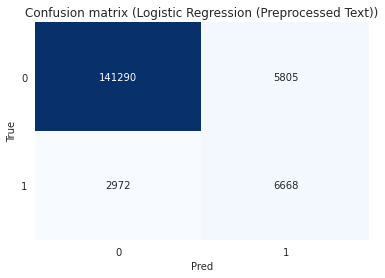

In [25]:
print("Model 1")

list_corpus=train['post_tokens_no_stopw'].tolist()
list_labels=train['target'].tolist()

#train test split
print('Splitting dataset into train and test subsets')

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print('Fitting Model')
  
#defining model and parameters
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='saga', multi_class='ovr', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

print('Model Parameters')
print(clf.get_params())
  
y_predicted_counts = clf.predict(X_test_counts)


print("-"*20)
print('Summarizing Results')
accuracy_cv, precision_cv, recall_cv, f1_cv = scores(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_cv, precision_cv,
                                                                       recall_cv, f1_cv))

print(classification_report(y_test,y_predicted_counts))

## Plot confusion matrix
classes = np.unique(y_test)
cm = confusion_matrix(y_test, y_predicted_counts)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix (Logistic Regression (Preprocessed Text))")
plt.yticks(rotation=0)

MODEL 2
* Without preprocessed Text
* Count Vectorizer: ngram_range=(1,6)
* Logistic Regression, parameters: class_weight='balanced', solver='saga', multi_class='ovr', n_jobs=-1, random_state=40

In [ ]:
print('MODEL 2: No Text Preprocessing, Count Vectorizer,Logistic Regression')

Model 2
Splitting dataset into train and test subsets
Fitting Model


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Model Parameters
{'C': 30.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 40, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
--------------------
Summarizing Results
accuracy = 0.952, precision = 0.597, recall = 0.651, f1 = 0.623
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    147095
           1       0.60      0.65      0.62      9640

    accuracy                           0.95    156735
   macro avg       0.79      0.81      0.80    156735
weighted avg       0.95      0.95      0.95    156735



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

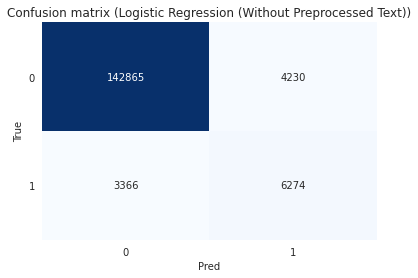

In [26]:
print("Model 2")

list_corpus=train['question_text'].tolist()
list_labels=train['target'].tolist()

print('Splitting dataset into train and test subsets')

#train test split
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print('Fitting Model')
  
#defining model and parameters
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='saga', multi_class='ovr', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)


print('Model Parameters')
print(clf.get_params())
  
y_predicted_counts = clf.predict(X_test_counts)

print("-"*20)
print('Summarizing Results')

accuracy_cv, precision_cv, recall_cv, f1_cv = scores(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_cv, precision_cv,
                                                                       recall_cv, f1_cv))

print(classification_report(y_test,y_predicted_counts))

## Plot confusion matrix
classes = np.unique(y_test)
cm = confusion_matrix(y_test, y_predicted_counts)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix (Logistic Regression (Without Preprocessed Text))")
plt.yticks(rotation=0)

MODEL 3

* Preprocessed Text
* TF-IDF: ngram_range=(1,6)
* Logistic Regression, parameters: class_weight='balanced', solver='saga', multi_class='ovr', n_jobs=-1, random_state=40

In [ ]:
print('MODEL 3:Text Preprocessing, TFIDF Vectorizer,Logistic Regression')

Splitting dataset into train and test subsets
Fitting Model


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


--------------------
Summarizing Results
accuracy = 0.906, precision = 0.382, recall = 0.852, f1 = 0.528
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    147095
           1       0.38      0.85      0.53      9640

    accuracy                           0.91    156735
   macro avg       0.69      0.88      0.74    156735
weighted avg       0.95      0.91      0.92    156735



(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

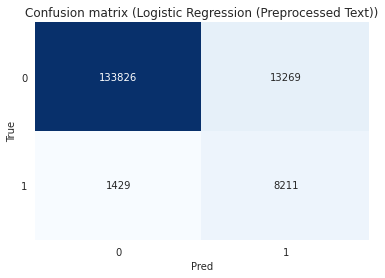

In [27]:
#tfidf, preprocessed text
list_corpus=train['post_tokens_no_stopw'].tolist()
list_labels=train['target'].tolist()

print('Splitting dataset into train and test subsets')

#train test split
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
X_train_counts, tfidf_vectorizer = tfidf(X_train)
X_test_counts = tfidf_vectorizer.transform(X_test)

print('Fitting Model')
  
#defining model and parameters
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='saga', multi_class='ovr', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
  
y_predicted_counts = clf.predict(X_test_counts)

print("-"*20)
print('Summarizing Results')

accuracy_cv, precision_cv, recall_cv, f1_cv = scores(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_cv, precision_cv,
                                                                       recall_cv, f1_cv))

print(classification_report(y_test,y_predicted_counts))

## Plot confusion matrix
classes = np.unique(y_test)
cm = confusion_matrix(y_test, y_predicted_counts)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix (Logistic Regression (Preprocessed Text))")
plt.yticks(rotation=0)

In [28]:
print('MODEL 4: No Text Preprocessing, TFIDF Vectorizer,Logistic Regression')

MODEL 4: No Text Preprocessing, TFIDF Vectorizer,Logistic Regression


MODEL 4

* Without preprocessing Text
* TF-IDF: ngram_range=(1,6)
* Logistic Regression, parameters: class_weight='balanced', solver='saga', multi_class='ovr', n_jobs=-1, random_state=40

In [ ]:
#tfidf, without preprocessing
list_corpus=train['question_text'].tolist()
list_labels=train['target'].tolist()

print('Splitting dataset into train and test subsets')

#train test split
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
X_train_counts, tfidf_vectorizer = tfidf(X_train)
X_test_counts = tfidf_vectorizer.transform(X_test)

print('Fitting Model')
  
#defining model and parameters
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='saga', multi_class='ovr', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
  
y_predicted_counts = clf.predict(X_test_counts)

print("-"*20)
print('Summarizing Results')

accuracy_cv, precision_cv, recall_cv, f1_cv = scores(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_cv, precision_cv,
                                                                       recall_cv, f1_cv))

print(classification_report(y_test,y_predicted_counts))

## Plot confusion matrix
classes = np.unique(y_test)
cm = confusion_matrix(y_test, y_predicted_counts)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix (Logistic Regression (Without Preprocessed Text))")
plt.yticks(rotation=0)

Splitting dataset into train and test subsets
